**EXPORT ZIP DATASET AND CREATE DIRECTORY FOR EACH CATEGORIZE OF MEATFRESHNESS**

In [ ]:
import os
import zipfile

# Extract the archive
zip_ref = zipfile.ZipFile("./MeatFreshness.zip", 'r')
zip_ref.extractall('tmp')

zip_ref.close()

# Directory with training fresh meat pictures 
train_frmeat_dir = os.path.join('Training/Fresh')
# Directory with training half fresh meat pictures 
train_hfmeat_dir = os.path.join('Training/HalfFresh')
# Directory with training spoiled meat pictures 
train_spmeat_dir = os.path.join('Training/Spoiled')
# Directory with training not valid pictures 
train_notmeat_dir = os.path.join('Training/NotValidImage')

# Directory with validation fresh meat pictures 
val_frmeat_dir = os.path.join('Validation/Fresh')
# Directory with validation half fresh meat pictures 
val_hfmeat_dir = os.path.join('Validation/HalfFresh')
# Directory with validation spoiled meat pictures 
val_spmeat_dir = os.path.join('Validation/Spoiled')
# Directory with validation not valid pictures 
val_notmeat_dir = os.path.join('Validation/NotValidImage')

**DISTRIBUTE IMAGES TO FOLDERS ACCORDING TO THEIR CLASSES**

In [ ]:
print("Training : ")
print(len(os.listdir('/content/tmp/MeatFreshness/Training/Fresh')))
print(len(os.listdir('/content/tmp/MeatFreshness/Training/HalfFresh')))
print(len(os.listdir('/content/tmp/MeatFreshness/Training/Spoiled')))
print(len(os.listdir('/content/tmp/MeatFreshness/Training/NotValidImage')))
print('\n')
print("Validation : ")
print(len(os.listdir('/content/tmp/MeatFreshness/Validation/Fresh')))
print(len(os.listdir('/content/tmp/MeatFreshness/Validation/HalfFresh')))
print(len(os.listdir('/content/tmp/MeatFreshness/Validation/Spoiled')))
print(len(os.listdir('/content/tmp/MeatFreshness/Validation/NotValidImage')))

Training : 
675
630
510
600


Validation : 
178
159
114
202


**PREPROCESSING OF THE IMAGE**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Apply data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory('tmp/MeatFreshness/Training', 
                                                    target_size=(150, 150),  # All images will be resized to 150x150
                                                    batch_size=32,
                                                    seed=42,
                                                    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory('tmp/MeatFreshness/Validation',
                                                      target_size=(150,150),
                                                      batch_size=32,
                                                      seed=42,
                                                      class_mode='categorical',
                                                      shuffle=False
)

Found 2415 images belonging to 4 classes.
Found 653 images belonging to 4 classes.


**BUILD THE MODEL**

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 128 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

**SET TRAINING PARAMETER**

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate =0.0001),
              metrics = ["accuracy"])

**CALLBACK FUCTION FOR HANDLE OVERFITTING**

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs = {}):
        if epoch >= 10 and logs.get("accuracy") - logs.get("val_accuracy") >= 0.1:
            print("Model tends to be overfitting, then Stop It")
            self.model.stop_training = True
        elif logs.get("accuracy") > 0.9:
            print("Model tends to be overfitting, then Stop It.")
            self.model.stop_training = True
callback = myCallback()

**TRAINING THE MODEL**

In [ ]:
history = model.fit(
      train_generator,  
      epochs=50,
      batch_size=32,
      validation_data = validation_generator,
      callbacks = [callback,],
      verbose = 1)

Epoch 1/50
76/76 [==============================] - 90s 1s/step - loss: 1.3616 - accuracy: 0.3602 - val_loss: 1.2722 - val_accuracy: 0.4809
Epoch 2/50
76/76 [==============================] - 86s 1s/step - loss: 1.0926 - accuracy: 0.4990 - val_loss: 0.9672 - val_accuracy: 0.5467
Epoch 3/50
76/76 [==============================] - 88s 1s/step - loss: 0.9365 - accuracy: 0.5449 - val_loss: 0.8802 - val_accuracy: 0.5926
Epoch 4/50
76/76 [==============================] - 85s 1s/step - loss: 0.8579 - accuracy: 0.6000 - val_loss: 0.8351 - val_accuracy: 0.6095
Epoch 5/50
76/76 [==============================] - 90s 1s/step - loss: 0.8296 - accuracy: 0.6091 - val_loss: 0.8190 - val_accuracy: 0.5957
Epoch 6/50
76/76 [==============================] - 89s 1s/step - loss: 0.8001 - accuracy: 0.6335 - val_loss: 0.8246 - val_accuracy: 0.6003
Epoch 7/50
76/76 [==============================] - 89s 1s/step - loss: 0.7833 - accuracy: 0.6273 - val_loss: 0.8115 - val_accuracy: 0.6064
Epoch 8/50
76/76 [==

**PLOT THE MODEL RESULT**

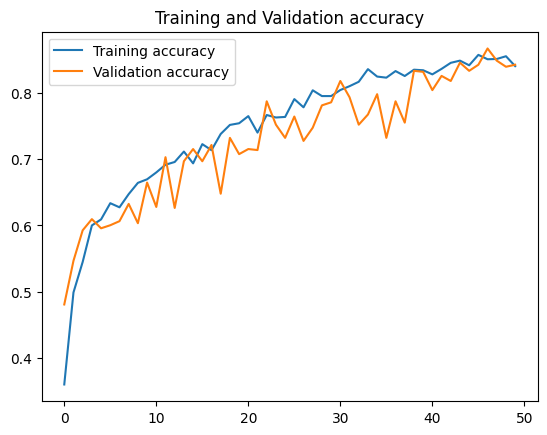

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs,acc,label = "Training accuracy")
plt.plot(epochs,val_acc,label = "Validation accuracy")
plt.title('Training and Validation accuracy')

plt.legend()
plt.show()

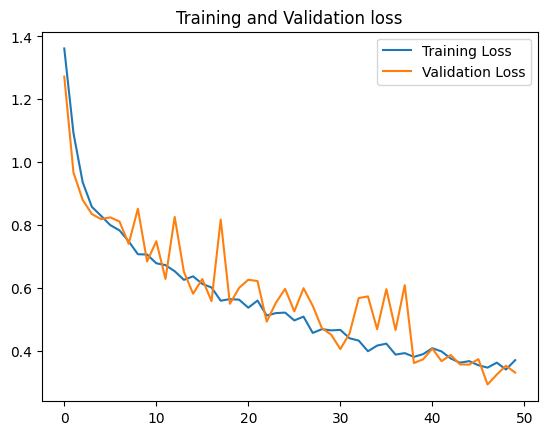

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(epochs,loss,label = "Training Loss")
plt.plot(epochs,val_loss,label = "Validation Loss")
plt.title('Training and Validation loss')

plt.legend()
plt.show()

**SAVE MODEL TO .H5**

In [ ]:
model.save("MeatFreshnessThird_classify.h5")

In [ ]:
my_model = tf.keras.models.load_model("MeatFreshnessThird_classify.h5")

**PREDICT IMAGE FROM THE INTERNET**

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np 

In [ ]:
def get_and_process(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img_1 = img
    #Resize image to fit the input size model
    img = img.resize((150,150))

    #Preprocessing image for the internet
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x / 255.0 
    x = np.expand_dims(x,axis = 0)
    img_tensor = np.vstack([x])
    return img_1,img_tensor

1/1 [==============================] - 0s 93ms/step
Prediction is : NotValidImage


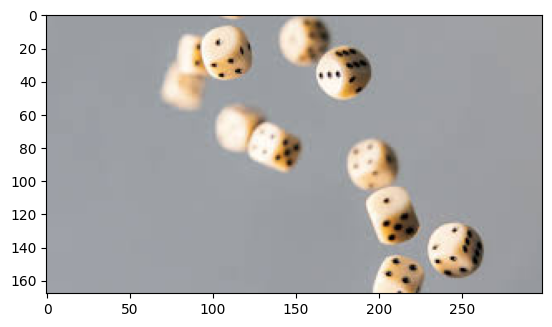

['Fresh', 'HalfFresh', 'NotValidImage', 'Spoiled']
[[2.3338600e-04 3.7734797e-05 9.8777580e-01 1.1953136e-02]]


In [ ]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ0Z0iLQ1fTwM42IAFuqVvcYCmVJcLNqhrxkQ&usqp=CAU"
img1,test_img = get_and_process(url)

pred = my_model.predict(test_img)
classes = list(train_generator.class_indices.keys())
print(f"Prediction is : {classes[np.argmax(pred)]}")
plt.imshow(img1)
plt.show()

print(classes)
print(pred)

**CONVERT MODEL FILE .H5 TO TFLITE**

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model('MeatFreshnessThird_classify.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflmodel = converter.convert()
file = open( 'MeatFreshness.tflite' , 'wb' ) 
file.write( tflmodel )

528892